# M8 Assignment

```
By: Nick Keeley
Adapted from Dr. Alvarado's M8/M8a notebooks

```

In [97]:
## Imports

from ssl import ALERT_DESCRIPTION_BAD_CERTIFICATE_HASH_VALUE
import pandas as pd
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation as LDA, NMF
import plotly.express as px

## Bring in

In [2]:
## Code provided by Dr. Alvarado

class TopicModel():            

    """
    A class to convert a BOW table into a topic model consisting of THETA, PHI, and TOPIC tables.
    Attributes:
        bow_count_col (str): The name of the token count column in the BOW table. Defaults to 'n'.
        n_term (int): The number of vocabalary terms to use in the topic model. Defaults to None.
        n_topics (int): The number of topics to generate. Defaults to 20.
        n_top_terms (int): The number of top terms to use to represent each topic. Will compute based on entropy if no value given. Defaults to None.
        engine_type (str): The topic modeling engine to use. May be 'LDA' or 'NMF'. Defaults to 'LDA'.
        alpha (float) = The document-topic prior, e.g. .1.  Defaults to None.
        beta (float) = The topic-term prior, e.g. .01.  Defaults to None.
        
        # LDA Params
        max_iter:int = 20
        learning_offset:float = 50.
        random_state:int = 0
        
        # NMF Params
        nmf_init:str = 'nndsvd'
        nmf_max_iter:int = 1000
        nmf_random_state:int = 1
        kw = {} # Extra parameters
    """

    # General
    bow_count_col:str = 'n'
    n_terms:int = None
    n_topics:int = 20
    n_top_terms:int = None
    engine_type:str = 'LDA' # Also NMF
    alpha:float = None # doc_topic_prior
    beta:float = None  # topic_word_prior
    
    # LDA Params
    max_iter:int = 20
    learning_offset:float = 50.
    random_state:int = 0
    
    # NMF Params
    nmf_init:str = 'nndsvd'
    nmf_max_iter:int = 1000
    nmf_random_state:int = 1

    kw = {} # Extra parameters
    
    def __init__(self, BOW:pd.DataFrame):
        """
        Initialize by passing a bag-of-words table with an OHCO index and 'n' feature of word counts.
        """
        self.BOW = BOW
        
    def create_X(self):
        
        # Convert BOW to DTM (X)
        X = self.BOW[self.bow_count_col].unstack(fill_value=0)

        # Reduce feature space if asked
        V = X[X > 0].sum().to_frame('df')
        if self.n_terms:
            V['idf'] = np.log2(len(X)/V.df)
            V['dfidf'] = V.df * V.idf
            SIGS = V.sort_values('dfidf', ascending=False).head(self.n_terms).index
            self.X = X[SIGS]
        else:
            self.X = X
        self.V = V        
        
    def get_model(self):
        
        if self.engine_type == 'LDA':
            self.engine = LDA(n_components=self.n_topics, 
                                max_iter=self.max_iter, 
                                doc_topic_prior=self.alpha,
                                topic_word_prior=self.beta,
                                learning_offset=self.learning_offset, 
                                random_state=self.random_state,
                                **self.kw)

        elif self.engine_type == 'NMF':
            self.engine = NMF(n_components=self.n_topics, 
                                max_iter=self.nmf_max_iter,
                                init=self.nmf_init, 
                                random_state=self.nmf_random_state, 
                                **self.kw)
                
        self.THETA = pd.DataFrame(self.engine.fit_transform(self.X.values), index=self.X.index)
        self.THETA.columns.name = 'topic_id'
        
        self.PHI = pd.DataFrame(self.engine.components_, columns=self.X.columns)
        self.PHI.index.name = 'topic_id'
        self.PHI.columns.name = 'term_str'
        
        self.TOPIC = self.PHI.sum(1).to_frame('phi_sum')
        self.TOPIC['theta_sum'] = self.THETA.sum()

    def describe_topics(self):
        
        # Compute topic entropy over PHI to get n for top terms
        PHI_P = (self.PHI.T / self.PHI.T.sum())
        PHI_I = np.log2(1/PHI_P)
        self.TOPIC['h'] = round((PHI_I * PHI_P).sum().sort_values(ascending=False), 2)
        if not self.n_top_terms:
            self.n_top_terms = round(self.TOPIC.h.mean())

        # Compute relevant terms
        self.get_relevant_terms(0)
        
        # Get top terms
        self.TOPIC['top_terms'] = self.PHI.apply(lambda x: ' '.join(x.sort_values(ascending=False).head(self.n_top_terms).index), 1)        
        self.TOPIC['label'] = self.TOPIC.apply(lambda x: f"{x.name}: {x.top_terms_rel}", 1)
        

    def get_relevant_terms(self, 𝜆 = .5):
        """
        Compute relevance of topic terms as defined by Sievert and Shirley 2014.
        C. Sievert and K. Shirley, “LDAvis: A Method for Visualizing and Interpreting Topics,” 
        in Proceedings of the workshop on interactive language learning, visualization, and interfaces, 2014, pp. 63–70.
        """
        Ptw = self.PHI.apply(lambda x: x / x.sum(), 1) # L1 norm of PHI rows, i.e. p(w|t)
        Pw = self.PHI.sum() / self.PHI.sum().sum() # Marginal probs of terms in PHI, i.e. p(w)
        self.REL = 𝜆 * np.log2(Ptw) + (1-𝜆) * np.log2(Ptw / Pw)
        self.TOPIC['top_terms_rel'] = self.REL.apply(lambda x: ' '.join(x.sort_values(ascending=False).head(self.n_top_terms).index), 1)

    def get_model_stats(self):
        self.entropy = self.TOPIC.h.sum()
        self.redundancy = 1 - self.entropy / np.log2(self.n_topics)
    
    def get_doc_stats(self):
        self.DOC = (self.THETA.T * np.log2(1/self.THETA.T)).sum().to_frame('entropy')
        self.DOC['max_topic'] = self.THETA.idxmax(1)
        
    def plot_topics(self):
        self.TOPIC.sort_values('theta_sum', ascending=True)\
            .plot.barh(y='theta_sum', x='label', figsize=(5, self.n_topics/2))

In [4]:
## Import data

LIB=pd.read_csv("okcupid-LIB.csv", index_col="doc_id")
BOW=pd.read_csv("okcupid-BOW.csv", index_col=['doc_id', 'term_str'])
BOW

n
doc_id term_str   
3      bataille  1
       beckett   1
       books     1
       cabaret   1
       cats      1
...             ..
59934  worked    1
       world     2
       year      1
       years     3
       yoga      1

[603878 rows x 1 columns]

In [6]:
## Create topic model objects

n_topics=40
n_terms=2000
tm=TopicModel(BOW)
tm.n_topics=n_topics
tm.n_terms=n_terms

In [7]:
## Methods

tm.create_X()


In [9]:
#tm.V

In [10]:
tm.get_model()

In [14]:
#tm.TOPIC

In [15]:
tm.describe_topics()

In [17]:
tm.get_model_stats()

In [210]:
## Question 1

tm.THETA.sum().sort_values(ascending=False) # topic 13
tm.TOPIC.iloc[13]

phi_sum                                                    23731.6
theta_sum                                                  335.183
h                                                             7.84
top_terms_rel    sporting golf bowling relax daughters listener...
top_terms         enjoy family someone person work laugh fun humor
label            13: sporting golf bowling relax daughters list...
Name: 13, dtype: object

In [168]:
## Question 2. Need doc_ids for age groups, then mean of topic concentrations across those docs

attributes=list(LIB.columns)
combined=pd.merge(LIB,tm.THETA,on="doc_id")
combined
sub=attributes[1:]
combined=combined.drop(sub,axis=1)
combined

,age,0,1,2,3,4,5,6,7,8,...,30,31,32,33,34,35,36,37,38,39
doc_id,,,,,,,,,,,,,,,,,,,,,
3,23,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,...,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.292047
14,29,0.000236,0.103912,0.000236,0.000236,0.000236,0.000236,0.000236,0.000236,0.000236,...,0.000236,0.000236,0.000236,0.000236,0.086246,0.000236,0.000236,0.000236,0.000236,0.000236
43,40,0.000108,0.000108,0.000108,0.000108,0.000108,0.000108,0.000108,0.000108,0.075383,...,0.000108,0.000108,0.000108,0.000108,0.000108,0.037928,0.000108,0.000108,0.158487,0.000108
48,31,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,0.099268,0.000185,0.000185,...,0.000185,0.000185,0.000185,0.018030,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185
73,31,0.000234,0.000234,0.051156,0.104796,0.000234,0.000234,0.019611,0.000234,0.000234,...,0.000234,0.000234,0.000234,0.026827,0.000234,0.075106,0.000234,0.000234,0.000234,0.112239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59887,32,0.000385,0.000385,0.000385,0.317546,0.000385,0.000385,0.000385,0.000385,0.000385,...,0.000385,0.000385,0.000385,0.000385,0.000385,0.000385,0.045948,0.000385,0.000385,0.000385
59909,37,0.000333,0.000333,0.000333,0.388912,0.000333,0.000333,0.000333,0.000333,0.000333,...,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333
59914,26,0.032957,0.056108,0.000135,0.000135,0.000135,0.000135,0.000135,0.000135,0.000135,...,0.000135,0.000135,0.000135,0.000135,0.000135,0.000135,0.000135,0.000135,0.000135,0.000135


In [169]:
combined_agg=combined.groupby("age").mean()
fig=px.imshow(combined_agg, aspect="auto")
fig.show() # topic 29 looks promising for older folks, topic 23 for younger

In [102]:
tm.TOPIC.iloc[29]

phi_sum                                                    33908.4
theta_sum                                                  315.364
h                                                                9
top_terms_rel    healing growth integrity intimacy awareness de...
top_terms        world others nature want enjoy someone dance feel
label            29: healing growth integrity intimacy awarenes...
Name: 29, dtype: object

In [105]:
tm.TOPIC.iloc[23]

phi_sum                                                    20372.3
theta_sum                                                   302.56
h                                                             8.02
top_terms_rel    cell hangover entourage notebook twilight phon...
top_terms              family movies get school know guy girl want
label            23: cell hangover entourage notebook twilight ...
Name: 23, dtype: object

In [170]:
## Question 4: income

attributes=list(LIB.columns)
combined=pd.merge(LIB,tm.THETA,on="doc_id")
combined
sub=attributes.copy()

In [171]:
sub.remove("income")
sub

['age',
 'body_type',
 'diet',
 'drinks',
 'drugs',
 'education',
 'ethnicity',
 'height',
 'job',
 'last_online',
 'location',
 'offspring',
 'orientation',
 'pets',
 'religion',
 'sex',
 'sign',
 'smokes',
 'speaks',
 'status',
 'doc_raw',
 'doc_clean']

In [172]:
combined=combined.drop(sub,axis=1)
combined

,income,0,1,2,3,4,5,6,7,8,...,30,31,32,33,34,35,36,37,38,39
doc_id,,,,,,,,,,,,,,,,,,,,,
3,20000,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,...,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.292047
14,50000,0.000236,0.103912,0.000236,0.000236,0.000236,0.000236,0.000236,0.000236,0.000236,...,0.000236,0.000236,0.000236,0.000236,0.086246,0.000236,0.000236,0.000236,0.000236,0.000236
43,60000,0.000108,0.000108,0.000108,0.000108,0.000108,0.000108,0.000108,0.000108,0.075383,...,0.000108,0.000108,0.000108,0.000108,0.000108,0.037928,0.000108,0.000108,0.158487,0.000108
48,1000000,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,0.099268,0.000185,0.000185,...,0.000185,0.000185,0.000185,0.018030,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185
73,50000,0.000234,0.000234,0.051156,0.104796,0.000234,0.000234,0.019611,0.000234,0.000234,...,0.000234,0.000234,0.000234,0.026827,0.000234,0.075106,0.000234,0.000234,0.000234,0.112239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59887,30000,0.000385,0.000385,0.000385,0.317546,0.000385,0.000385,0.000385,0.000385,0.000385,...,0.000385,0.000385,0.000385,0.000385,0.000385,0.000385,0.045948,0.000385,0.000385,0.000385
59909,50000,0.000333,0.000333,0.000333,0.388912,0.000333,0.000333,0.000333,0.000333,0.000333,...,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333
59914,30000,0.032957,0.056108,0.000135,0.000135,0.000135,0.000135,0.000135,0.000135,0.000135,...,0.000135,0.000135,0.000135,0.000135,0.000135,0.000135,0.000135,0.000135,0.000135,0.000135


In [173]:
combined_agg=combined.groupby("income").mean()
combined_agg.style.background_gradient(cmap='GnBu',axis=None)
#fig.show() # topic 13, 250000

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
income,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20000,0.014492,0.013500,0.014498,0.025087,0.018072,0.010432,0.011392,0.007764,0.022936,0.025409,0.010327,0.063983,0.073842,0.030475,0.012439,0.017382,0.035144,0.021750,0.010071,0.018366,0.006914,0.028802,0.024656,0.081231,0.022552,0.025099,0.017822,0.079590,0.023821,0.042985,0.031726,0.021985,0.008548,0.005000,0.014998,0.015908,0.039208,0.015736,0.022168,0.013888
30000,0.020379,0.014119,0.020971,0.018117,0.026514,0.010655,0.009776,0.007775,0.027360,0.019097,0.014989,0.060874,0.066128,0.055811,0.010204,0.009088,0.031422,0.027878,0.010459,0.022223,0.007190,0.028505,0.028956,0.060130,0.024871,0.019838,0.026246,0.053510,0.018248,0.047123,0.030292,0.015112,0.013086,0.003641,0.024583,0.018081,0.033287,0.015056,0.034997,0.013409
40000,0.015361,0.011211,0.013170,0.017375,0.021032,0.013876,0.010481,0.009311,0.022100,0.017114,0.013850,0.049143,0.053417,0.057553,0.010933,0.011488,0.031847,0.022905,0.023198,0.017588,0.010786,0.035864,0.032802,0.052581,0.026342,0.019419,0.035668,0.046597,0.025609,0.062571,0.031281,0.016253,0.011278,0.006763,0.037642,0.018034,0.028096,0.014904,0.031297,0.013259
50000,0.014942,0.011391,0.018507,0.015205,0.022398,0.016384,0.010291,0.004469,0.025558,0.016147,0.011206,0.044966,0.045406,0.074666,0.011159,0.009333,0.024235,0.018655,0.024097,0.023224,0.007584,0.038022,0.036565,0.054607,0.037803,0.013096,0.019490,0.045105,0.030113,0.067209,0.020209,0.021741,0.007751,0.005049,0.046900,0.018610,0.023943,0.013901,0.032820,0.017244
60000,0.012952,0.007091,0.013125,0.017772,0.017847,0.013134,0.012434,0.006545,0.024930,0.011880,0.011923,0.047048,0.047558,0.081036,0.012708,0.010827,0.026739,0.022863,0.030330,0.013358,0.009033,0.046452,0.039884,0.037911,0.037249,0.015280,0.036497,0.031802,0.031273,0.064802,0.021582,0.011595,0.013407,0.003428,0.045065,0.014306,0.023480,0.016857,0.037628,0.020369
70000,0.021879,0.010835,0.024763,0.017478,0.022430,0.020338,0.010144,0.010378,0.022584,0.012165,0.016801,0.036680,0.046096,0.090637,0.011744,0.012994,0.019529,0.018760,0.031387,0.013943,0.010187,0.036065,0.033700,0.036261,0.034399,0.011038,0.034706,0.033064,0.024692,0.059127,0.024689,0.019395,0.009579,0.006041,0.064121,0.016021,0.018889,0.010655,0.029256,0.016552
80000,0.029446,0.010198,0.012642,0.009989,0.022947,0.026557,0.013193,0.005139,0.023072,0.011747,0.017018,0.041199,0.044577,0.077442,0.012098,0.010933,0.018898,0.014771,0.039293,0.024658,0.012350,0.038544,0.041807,0.034903,0.034410,0.011918,0.028612,0.033325,0.015801,0.066908,0.015071,0.016246,0.011809,0.004134,0.068168,0.016605,0.020572,0.010591,0.036428,0.015981
100000,0.027497,0.008072,0.013643,0.011477,0.021271,0.030185,0.016117,0.007889,0.026420,0.009965,0.014928,0.051518,0.037724,0.073107,0.017705,0.006772,0.024790,0.012199,0.046568,0.018416,0.010619,0.033252,0.049820,0.023833,0.044959,0.007562,0.037771,0.023394,0.015474,0.063245,0.018883,0.016131,0.009133,0.004741,0.067926,0.013287,0.021711,0.011150,0.036730,0.014113
150000,0.022065,0.008972,0.021876,0.008341,0.025033,0.044226,0.016422,0.006975,0.020034,0.009692,0.014757,0.060288,0.034262,0.073742,0.013361,0.008288,0.015566,0.010887,0.059535,0.009985,0.008726,0.023861,0.054887,0.024298,0.055148,0.011058,0.025376,0.014784,0.019049,0.041824,0.018776,0.013404,0.007178,0.005481,0.085914,0.011804,0.020937,0.012934,0.046500,0.013754


In [167]:
tm.TOPIC.iloc[13]

phi_sum                                                    23731.6
theta_sum                                                  335.183
h                                                             7.84
top_terms_rel    sporting golf bowling relax daughters listener...
top_terms         enjoy family someone person work laugh fun humor
label            13: sporting golf bowling relax daughters list...
Name: 13, dtype: object

In [174]:
## Question 5. Need doc_ids for sex, then mean of topic concentrations across those docs

attributes=list(LIB.columns)
combined=pd.merge(LIB,tm.THETA,on="doc_id")
combined
sub=attributes.copy()

In [175]:
sub.remove("sex")

In [176]:
combined=combined.drop(sub,axis=1)
combined

,sex,0,1,2,3,4,5,6,7,8,...,30,31,32,33,34,35,36,37,38,39
doc_id,,,,,,,,,,,,,,,,,,,,,
3,m,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,...,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.292047
14,f,0.000236,0.103912,0.000236,0.000236,0.000236,0.000236,0.000236,0.000236,0.000236,...,0.000236,0.000236,0.000236,0.000236,0.086246,0.000236,0.000236,0.000236,0.000236,0.000236
43,m,0.000108,0.000108,0.000108,0.000108,0.000108,0.000108,0.000108,0.000108,0.075383,...,0.000108,0.000108,0.000108,0.000108,0.000108,0.037928,0.000108,0.000108,0.158487,0.000108
48,f,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,0.099268,0.000185,0.000185,...,0.000185,0.000185,0.000185,0.018030,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185
73,f,0.000234,0.000234,0.051156,0.104796,0.000234,0.000234,0.019611,0.000234,0.000234,...,0.000234,0.000234,0.000234,0.026827,0.000234,0.075106,0.000234,0.000234,0.000234,0.112239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59887,f,0.000385,0.000385,0.000385,0.317546,0.000385,0.000385,0.000385,0.000385,0.000385,...,0.000385,0.000385,0.000385,0.000385,0.000385,0.000385,0.045948,0.000385,0.000385,0.000385
59909,f,0.000333,0.000333,0.000333,0.388912,0.000333,0.000333,0.000333,0.000333,0.000333,...,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333
59914,f,0.032957,0.056108,0.000135,0.000135,0.000135,0.000135,0.000135,0.000135,0.000135,...,0.000135,0.000135,0.000135,0.000135,0.000135,0.000135,0.000135,0.000135,0.000135,0.000135


In [206]:
combined_agg=combined.groupby("sex").mean()
combined_agg.style.background_gradient(cmap='GnBu',axis=None)
temp=abs(combined_agg.loc["f"]-combined_agg.loc["m"])
combined_agg.columns
abs(combined_agg.loc["f"]-combined_agg.loc['m']).max()
#combined_agg.loc["m"].max() # Males: topics 11,12
#combined_agg.loc["f"].max() # females: topic 29

0.02270552650277334

In [198]:
tm.TOPIC.iloc[29]

phi_sum                                                    33908.4
theta_sum                                                  315.364
h                                                                9
top_terms_rel    healing growth integrity intimacy awareness de...
top_terms        world others nature want enjoy someone dance feel
label            29: healing growth integrity intimacy awarenes...
Name: 29, dtype: object

In [87]:
df = pd.DataFrame([[1, 2, 3],

                   [4, 5, 6],

                   [7, 8, 9],

                   [np.nan, np.nan, np.nan]],

                  columns=['A', 'B', 'C'])
df

,A,B,C
0,1.0,2.0,3.0
1,4.0,5.0,6.0
2,7.0,8.0,9.0
3,NaN,NaN,NaN


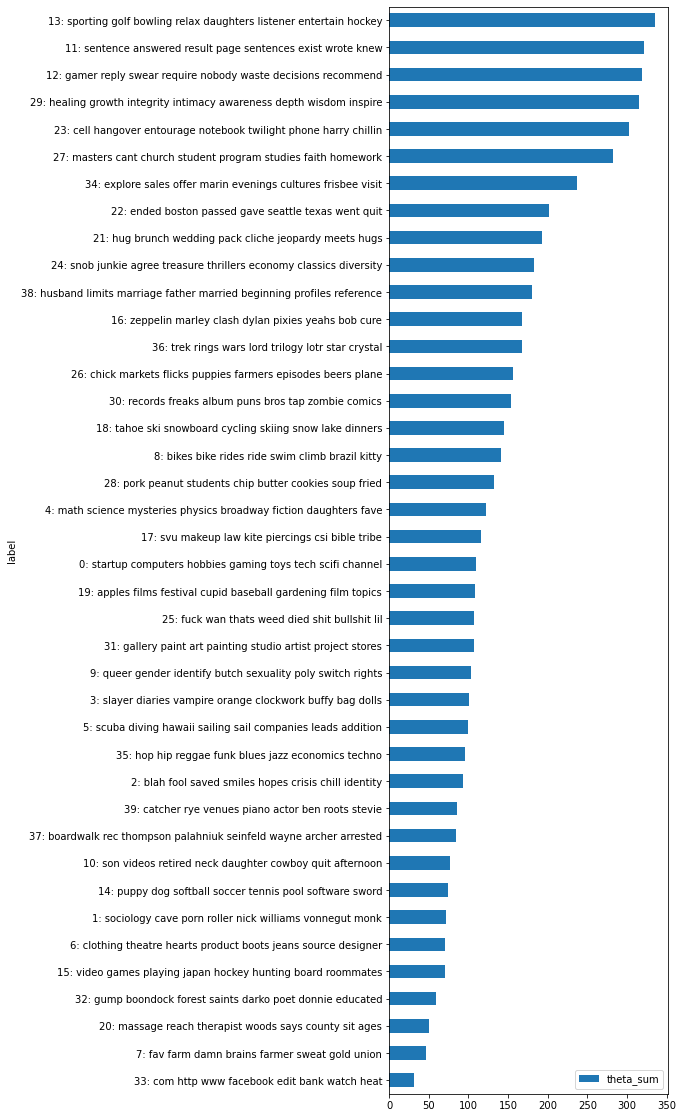

In [18]:
## Visualize

tm.plot_topics()